# Medida de proximidad

* Se mide la proximidad utilizando un método basado en resultados, en particular, basado en la suposición de que es más probable que productos similares se exporten en conjunto. 

* Para eso se requiere una medida estricta de las exportaciones. Se excluyen exportaciones marginales a través de la selección de exportaciones con Ventajas Comparativas Reveladas (VCR). Hidalgo et al (2007) usan la definición de Balassa (1986) de VCR.

### Cálculo de VCR (Balassa)

$ VCR_{ci} = \frac{ \frac{X_{ci}}{X_c} }{ \frac{X_{wi}}{X_w} } $ 

Donde $X_{ci}$ son las exportaciones del producto i del país c, mientras que $X_c$ son las exportaciones totales del país c. En el denominador se encuentran los análogos del resto del mundo (w).

## Datos de Comercio

En el paper original se usan productos desagregados según la SITC revisión 4 a nivel de cuatro dígitos, de la base de datos de UNCOMTRADE. En este caso se utilizarán datos de WITS correspondientes al sistema armonizado (HS) a 4 dígitos (ver extrating data de la carpeta de raw data => WITS).  

Levanto los datos ya preprocesados.

In [2]:
import numpy as np
import pandas as pd

In [63]:
df = pd.read_csv('C:/Users/sperini.NOTEBOOK44/Documents/Git/product-space/data/processed/datos_expo_para_vcr.csv', index_col=None)

In [64]:
df

,ReporterISO3,ProductCode,ReporterName,1997,1998,1999,2007,2008,2009,2017,2018,2019,prom_1719,prom_0709,prom_9799
0,ABW,101,Aruba,NaN,NaN,NaN,1.809,1.285,4.476,6.145,5.397,8.483,6.68,2.52,NaN
1,ABW,103,Aruba,NaN,NaN,NaN,NaN,NaN,0.084,NaN,NaN,NaN,NaN,0.08,NaN
2,ABW,104,Aruba,NaN,NaN,NaN,0.642,0.017,NaN,NaN,NaN,NaN,NaN,0.33,NaN
3,ABW,105,Aruba,NaN,NaN,NaN,6.849,1.531,4.473,27.374,73.884,47.781,49.68,4.28,NaN
4,ABW,106,Aruba,NaN,NaN,NaN,5.834,10.069,10.007,12.024,10.594,4.669,9.10,8.64,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179597,ZWE,9702,Zimbabwe,NaN,NaN,NaN,NaN,0.002,NaN,0.655,NaN,NaN,0.66,0.00,NaN
179598,ZWE,9703,Zimbabwe,NaN,NaN,NaN,4844.384,690.542,966.129,2261.126,2253.457,2172.791,2229.12,2167.02,NaN
179599,ZWE,9704,Zimbabwe,NaN,NaN,NaN,2.376,NaN,NaN,NaN,NaN,NaN,NaN,2.38,NaN
179600,ZWE,9705,Zimbabwe,NaN,NaN,NaN,30099.052,29621.528,14193.067,8866.771,8995.939,8252.694,8705.13,24637.88,NaN


In [72]:
# si quisiera seleccionar solo columnas numéricas 
# numeric_inputs = df.select_dtypes(include=np.number)
df['ProductCode'].nunique()

1242

In [94]:
df_ = df[["ReporterISO3", "ProductCode", 'ReporterName', 'prom_1719', 'prom_0709', 'prom_9799']]
df_

,ReporterISO3,ProductCode,ReporterName,prom_1719,prom_0709,prom_9799
0,ABW,101,Aruba,6.68,2.52,NaN
1,ABW,103,Aruba,NaN,0.08,NaN
2,ABW,104,Aruba,NaN,0.33,NaN
3,ABW,105,Aruba,49.68,4.28,NaN
4,ABW,106,Aruba,9.10,8.64,NaN
...,...,...,...,...,...,...
179597,ZWE,9702,Zimbabwe,0.66,0.00,NaN
179598,ZWE,9703,Zimbabwe,2229.12,2167.02,NaN
179599,ZWE,9704,Zimbabwe,NaN,2.38,NaN
179600,ZWE,9705,Zimbabwe,8705.13,24637.88,NaN


In [95]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179602 entries, 0 to 179601
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ReporterISO3  179602 non-null  object 
 1   ProductCode   179602 non-null  int64  
 2   ReporterName  179602 non-null  object 
 3   prom_1719     147283 non-null  float64
 4   prom_0709     152110 non-null  float64
 5   prom_9799     108184 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 8.2+ MB


In [96]:
df_.ProductCode.nunique()

1242

## Calculo VCR 

$ VCR_{ci} = \frac{ \frac{X_{ci}}{X_c} }{ \frac{X_{wi}}{X_w} } $ 

Gran parte del código que se aplica a continuación proviene de [QuantEconNotes](https://notes.quantecon.org/submission/5b32e9b0b9eab00015b89f7d) adaptado a los datos con los que estamos trabajando. Siempre siguiendo los lineamientos de la presente investigación y el paper original de Hidalgo et al. (2007). 

In [97]:
list_years = ['1719', '0709', '9799']
# armo los datos para el cálculo según la fórmula de Balassa
for i in list_years:
    # renombro columna de prom de expo 1719
    df_.rename(columns = {'prom_'+i:'X_c_prod_'+i}, inplace = True)
    # armo columna con el total de expo por pais
    df_['X_c_'+i] = df_[["ReporterName", 'X_c_prod_'+i]].groupby(by=["ReporterName"]).transform(np.sum)
    # armo una columna con el total de expo por producto (total mundial) 
    df_['X_w_prod_'+i] = df_[['ProductCode', 'X_c_prod_'+i]].groupby(by=["ProductCode"]).transform(np.sum)
    # armo una columna con el total de expo mundial (sumo todos los paises de la base)
    df_['X_w_'+i] = np.repeat(df_[['X_c_prod_'+i]].sum(), len(df_)).to_numpy()

C:\Programas\miniconda3\lib\site-packages\pandas\core\frame.py:4293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-97-cd87797d1eca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['X_c_'+i] = df_[["ReporterName", 'X_c_prod_'+i]].groupby(by=["ReporterName"]).transform(np.sum)
<ipython-input-97-cd87797d1eca>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [98]:
df_

,ReporterISO3,ProductCode,ReporterName,X_c_prod_1719,X_c_prod_0709,X_c_prod_9799,X_c_1719,X_w_prod_1719,X_w_1719,X_c_0709,X_w_prod_0709,X_w_0709,X_c_9799,X_w_prod_9799,X_w_9799
0,ABW,101,Aruba,6.68,2.52,NaN,82523.51,3.667820e+06,2.015527e+10,128281.49,2.864787e+06,1.511313e+10,0.0,1.223046e+06,5.147891e+09
1,ABW,103,Aruba,NaN,0.08,NaN,82523.51,4.380636e+06,2.015527e+10,128281.49,4.042493e+06,1.511313e+10,0.0,1.507012e+06,5.147891e+09
2,ABW,104,Aruba,NaN,0.33,NaN,82523.51,1.970374e+06,2.015527e+10,128281.49,1.206759e+06,1.511313e+10,0.0,5.875669e+05,5.147891e+09
3,ABW,105,Aruba,49.68,4.28,NaN,82523.51,3.539347e+06,2.015527e+10,128281.49,2.349412e+06,1.511313e+10,0.0,9.559928e+05,5.147891e+09
4,ABW,106,Aruba,9.10,8.64,NaN,82523.51,1.588165e+06,2.015527e+10,128281.49,8.720340e+05,1.511313e+10,0.0,3.599512e+05,5.147891e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179597,ZWE,9702,Zimbabwe,0.66,0.00,NaN,3942767.20,8.286066e+05,2.015527e+10,1891236.93,5.078966e+05,1.511313e+10,0.0,1.618647e+05,5.147891e+09
179598,ZWE,9703,Zimbabwe,2229.12,2167.02,NaN,3942767.20,5.763538e+06,2.015527e+10,1891236.93,3.005604e+06,1.511313e+10,0.0,5.402538e+05,5.147891e+09
179599,ZWE,9704,Zimbabwe,NaN,2.38,NaN,3942767.20,1.735062e+05,2.015527e+10,1891236.93,2.281169e+05,1.511313e+10,0.0,1.852215e+05,5.147891e+09
179600,ZWE,9705,Zimbabwe,8705.13,24637.88,NaN,3942767.20,1.831003e+06,2.015527e+10,1891236.93,7.690941e+05,1.511313e+10,0.0,3.399055e+05,5.147891e+09


In [99]:
# cuento los países para los que no se disponen de datos en los distintos años
print(df_[["ReporterName", 'X_c_prod_9799']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 67 países no tienen datos para 9799
print(df_[["ReporterName", 'X_c_prod_0709']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 13 países no tienen datos para 0709
print(df_[["ReporterName", 'X_c_prod_1719']].groupby(by=["ReporterName"]).sum().eq(0).sum()) # 27 países no tienen datos para 1719
# coinciden con los calculados antes

X_c_prod_9799    67
dtype: int64
X_c_prod_0709    13
dtype: int64
X_c_prod_1719    27
dtype: int64


In [100]:
# cálculo VCR según la fórmula de Balassa usando las columnas previamente creadas
for i in list_years:
    df_['VCR_ci'+i] = (df_['X_c_prod_'+i] / df_['X_c_'+i]) / (df_['X_w_prod_'+i] / df_['X_w_'+i])

In [101]:
df_

,ReporterISO3,ProductCode,ReporterName,X_c_prod_1719,X_c_prod_0709,X_c_prod_9799,X_c_1719,X_w_prod_1719,X_w_1719,X_c_0709,X_w_prod_0709,X_w_0709,X_c_9799,X_w_prod_9799,X_w_9799,VCR_ci1719,VCR_ci0709,VCR_ci9799
0,ABW,101,Aruba,6.68,2.52,NaN,82523.51,3.667820e+06,2.015527e+10,128281.49,2.864787e+06,1.511313e+10,0.0,1.223046e+06,5.147891e+09,0.444815,0.103633,NaN
1,ABW,103,Aruba,NaN,0.08,NaN,82523.51,4.380636e+06,2.015527e+10,128281.49,4.042493e+06,1.511313e+10,0.0,1.507012e+06,5.147891e+09,NaN,0.002331,NaN
2,ABW,104,Aruba,NaN,0.33,NaN,82523.51,1.970374e+06,2.015527e+10,128281.49,1.206759e+06,1.511313e+10,0.0,5.875669e+05,5.147891e+09,NaN,0.032217,NaN
3,ABW,105,Aruba,49.68,4.28,NaN,82523.51,3.539347e+06,2.015527e+10,128281.49,2.349412e+06,1.511313e+10,0.0,9.559928e+05,5.147891e+09,3.428225,0.214622,NaN
4,ABW,106,Aruba,9.10,8.64,NaN,82523.51,1.588165e+06,2.015527e+10,128281.49,8.720340e+05,1.511313e+10,0.0,3.599512e+05,5.147891e+09,1.399447,1.167269,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179597,ZWE,9702,Zimbabwe,0.66,0.00,NaN,3942767.20,8.286066e+05,2.015527e+10,1891236.93,5.078966e+05,1.511313e+10,0.0,1.618647e+05,5.147891e+09,0.004072,0.000000,NaN
179598,ZWE,9703,Zimbabwe,2229.12,2167.02,NaN,3942767.20,5.763538e+06,2.015527e+10,1891236.93,3.005604e+06,1.511313e+10,0.0,5.402538e+05,5.147891e+09,1.977114,5.761556,NaN
179599,ZWE,9704,Zimbabwe,NaN,2.38,NaN,3942767.20,1.735062e+05,2.015527e+10,1891236.93,2.281169e+05,1.511313e+10,0.0,1.852215e+05,5.147891e+09,NaN,0.083374,NaN
179600,ZWE,9705,Zimbabwe,8705.13,24637.88,NaN,3942767.20,1.831003e+06,2.015527e+10,1891236.93,7.690941e+05,1.511313e+10,0.0,3.399055e+05,5.147891e+09,24.303762,255.995577,NaN


In [102]:
df_['ProductCode'].nunique()

1242

In [103]:
df_['ProductCode'].to_numpy()

array([ 101,  103,  104, ..., 9704, 9705, 9999], dtype=int64)

## Cálculo de Matriz de VCR(c,i) 

### 1) Defino umbral para determinar si un país es exportador de un producto 

VCR(c,i) > 1 cuando la participación de las exportaciones de un país en un producto dado es mayor que la participación de ese producto en el comercio mundial. Esta definición de VCR permite establecer un **umbral para la exportación de un país**. Cuando **VCR >= 1 se considera que el país c exporta el producto i**, y cuando VCR(c, i) < 1 ese país no es un exportador de ese producto. 

### 2) Armo una matriz de dummies de VCRs $MVCR_{ci}$ tal que:

\begin{equation}
       MVCR_{ci} = 
        \begin{cases}
            1 & \text{si $VCR_{ci} >= 1 $} \\
            0 & \text{si $VCR_{ci} < 1 $}
        \end{cases}
\end{equation}


In [104]:
# pruebo con uno para luego replicar
df_.set_index(['ReporterISO3', 'ProductCode']).unstack('ProductCode')['VCR_ci1719']

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9616,9617,9618,9701,9702,9703,9704,9705,9706,9999
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ABW,0.444815,NaN,NaN,NaN,3.428225,1.399447,0.000101,0.023699,0.004503,NaN,...,NaN,0.005555,0.026967,0.130927,1.683056,0.037715,143.679236,NaN,0.614004,1.270098
AFG,NaN,NaN,NaN,0.035752,NaN,NaN,NaN,NaN,NaN,1.008270,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.601356
AGO,0.000030,0.000723,0.000070,NaN,0.000716,0.117291,0.000056,0.000603,0.000564,0.000079,...,0.000029,0.019112,0.011613,0.001984,0.000930,0.000449,NaN,NaN,0.000837,0.007535
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.664692
AND,2.321332,NaN,NaN,0.033778,NaN,NaN,NaN,0.019108,NaN,NaN,...,0.016392,0.113405,0.821911,0.372898,10.551586,2.777074,190.120929,0.791703,0.468997,0.102901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,NaN,NaN,0.194092,NaN,NaN,0.047238,0.219103,0.381543,0.332097,2.668859,...,0.554149,NaN,NaN,0.009828,NaN,0.026756,NaN,NaN,NaN,0.124042
YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZAF,0.493262,0.478800,0.055843,0.758078,0.593740,2.956210,0.706471,0.506456,0.149812,0.096528,...,0.349855,0.057789,0.225098,0.366379,0.290921,0.830157,0.082273,2.625075,0.003019,0.067411


In [105]:
# Genero matrices MVCR por cada prom de años considerado y las guardo en un diccionario 
VCR = {}
for i in list_years:
    data_anual = df_.set_index(['ReporterISO3', 'ProductCode']).unstack('ProductCode')['VCR_ci'+i]
    VCR[i] = data_anual

In [106]:
VCR

{'1719': ProductCode       101       102       103       104       105       106   \
 ReporterISO3                                                               
 ABW           0.444815       NaN       NaN       NaN  3.428225  1.399447   
 AFG                NaN       NaN       NaN  0.035752       NaN       NaN   
 AGO           0.000030  0.000723  0.000070       NaN  0.000716  0.117291   
 ALB                NaN       NaN       NaN       NaN       NaN       NaN   
 AND           2.321332       NaN       NaN  0.033778       NaN       NaN   
 ...                ...       ...       ...       ...       ...       ...   
 WSM                NaN       NaN  0.194092       NaN       NaN  0.047238   
 YEM                NaN       NaN       NaN       NaN       NaN       NaN   
 ZAF           0.493262  0.478800  0.055843  0.758078  0.593740  2.956210   
 ZMB           0.008852  0.018627  0.004772  0.001623  3.943438  0.188636   
 ZWE           0.064781  0.022957  0.004038       NaN  1.214690  3.2

In [107]:
VCR.keys()

dict_keys(['1719', '0709', '9799'])

In [108]:
# chequeo la matriz para un año a ver cómo quedó 
VCR['1719']

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9616,9617,9618,9701,9702,9703,9704,9705,9706,9999
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ABW,0.444815,NaN,NaN,NaN,3.428225,1.399447,0.000101,0.023699,0.004503,NaN,...,NaN,0.005555,0.026967,0.130927,1.683056,0.037715,143.679236,NaN,0.614004,1.270098
AFG,NaN,NaN,NaN,0.035752,NaN,NaN,NaN,NaN,NaN,1.008270,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.601356
AGO,0.000030,0.000723,0.000070,NaN,0.000716,0.117291,0.000056,0.000603,0.000564,0.000079,...,0.000029,0.019112,0.011613,0.001984,0.000930,0.000449,NaN,NaN,0.000837,0.007535
ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.664692
AND,2.321332,NaN,NaN,0.033778,NaN,NaN,NaN,0.019108,NaN,NaN,...,0.016392,0.113405,0.821911,0.372898,10.551586,2.777074,190.120929,0.791703,0.468997,0.102901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,NaN,NaN,0.194092,NaN,NaN,0.047238,0.219103,0.381543,0.332097,2.668859,...,0.554149,NaN,NaN,0.009828,NaN,0.026756,NaN,NaN,NaN,0.124042
YEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZAF,0.493262,0.478800,0.055843,0.758078,0.593740,2.956210,0.706471,0.506456,0.149812,0.096528,...,0.349855,0.057789,0.225098,0.366379,0.290921,0.830157,0.082273,2.625075,0.003019,0.067411


In [109]:
# Genero la Matriz MVCR a partir de las matrices previas
# También creo un diccioario que contenga los resultados de cada prom de años
MVCR = {}
for i in VCR.keys():
    # convierto los Na en 0 y aplico función lambda que si el valor de VCR es mayor a 1 devuelva 1 y si es menor devuelva 0
    MVCR[i] = VCR[i].fillna(0.0).applymap(lambda x: 1 if x >= 1.0 else 0.0)

In [110]:
MVCR['1719']

ProductCode,101,102,103,104,105,106,201,202,203,204,...,9616,9617,9618,9701,9702,9703,9704,9705,9706,9999
ReporterISO3,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AND,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YEM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZAF,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Productos que exporta Argentina según el umbral definido

Para los 3 períodos considerados se analizaron los productos que Argentina exporta con el criterio considerado: 

* Argentina ha incrementado el número de productos con VCR >= 1. Pasando de 133 en 1997-99 a 173 en 2017-19

In [111]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 1719 según el umbral definido de VCR >=1
prod_exp_ARG = MVCR['1719'].loc['ARG']
print(prod_exp_ARG[prod_exp_ARG == 1.0].sum()) # 173 bienes 
prod_exp_ARG[prod_exp_ARG == 1.0].index.to_numpy()

152.0


array([ 101,  201,  202,  205,  206,  207,  208,  303,  304,  306,  307,
        402,  404,  405,  406,  408,  409,  504,  505,  506,  510,  511,
        703,  711,  713,  805,  806,  808,  809,  810,  813,  902,  903,
        909, 1001, 1003, 1005, 1006, 1007, 1008, 1101, 1103, 1104, 1107,
       1201, 1202, 1204, 1206, 1207, 1208, 1209, 1214, 1401, 1502, 1503,
       1505, 1507, 1508, 1509, 1512, 1515, 1517, 1518, 1520, 1521, 1602,
       1701, 1901, 2004, 2005, 2007, 2008, 2009, 2102, 2204, 2206, 2301,
       2302, 2303, 2304, 2305, 2306, 2308, 2309, 2401, 2508, 2509, 2512,
       2518, 2522, 2528, 2603, 2607, 2616, 2713, 2803, 2810, 2813, 2819,
       2827, 2830, 2836, 2840, 2923, 3103, 3201, 3202, 3301, 3307, 3405,
       3501, 3502, 3503, 3507, 3602, 3805, 3806, 3808, 3812, 3817, 3823,
       3824, 3913, 4101, 4104, 4201, 4206, 4302, 4402, 4409, 4703, 4811,
       5101, 5103, 5105, 5201, 5202, 5803, 6807, 6809, 6908, 7106, 7108,
       7304, 7601, 7605, 7801, 8408, 8704, 8904, 93

In [112]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 0709 según el umbral definido de VCR >=1
prod_exp_ARG_ = MVCR['0709'].loc['ARG']
print(prod_exp_ARG_[prod_exp_ARG_ == 1.0].sum()) # 155 bienes 
prod_exp_ARG_[prod_exp_ARG_ == 1.0].index.to_numpy()

202.0


array([ 101,  201,  202,  204,  205,  206,  207,  208,  303,  304,  305,
        306,  307,  402,  404,  405,  406,  408,  409,  504,  505,  506,
        510,  511,  703,  711,  713,  805,  806,  808,  809,  810,  811,
        813,  814,  902,  903, 1001, 1003, 1005, 1006, 1007, 1008, 1101,
       1102, 1103, 1104, 1105, 1107, 1108, 1201, 1202, 1204, 1206, 1207,
       1401, 1502, 1503, 1505, 1507, 1508, 1509, 1512, 1515, 1517, 1518,
       1520, 1521, 1602, 1603, 1701, 1702, 1704, 1806, 1901, 2004, 2005,
       2007, 2008, 2009, 2102, 2204, 2206, 2207, 2301, 2302, 2304, 2305,
       2306, 2307, 2308, 2309, 2401, 2508, 2509, 2518, 2522, 2528, 2603,
       2616, 2711, 2713, 2716, 2803, 2810, 2813, 2819, 2824, 2827, 2830,
       2833, 2836, 2840, 2841, 2845, 2849, 2905, 2918, 2923, 2929, 2937,
       3102, 3201, 3202, 3211, 3301, 3305, 3307, 3401, 3405, 3501, 3502,
       3503, 3506, 3507, 3602, 3702, 3706, 3801, 3805, 3806, 3808, 3815,
       3817, 3823, 3824, 3901, 3904, 3908, 3913, 39

In [118]:
# Veo cuáles y cuántos son los productos que exporta Argentina en 9799 según el umbral definido de VCR >=1
prod_exp_ARG__ = MVCR['9799'].loc['ARG']
print(prod_exp_ARG__[prod_exp_ARG__ == 1.0].sum()) # 133 bienes 
prod_exp_ARG__[prod_exp_ARG__ == 1.0].index.to_numpy()

187.0


array([ 101,  201,  202,  205,  206,  208,  303,  304,  305,  306,  307,
        402,  406,  408,  409,  503,  506,  510,  511,  703,  711,  712,
        713,  805,  806,  808,  809,  813,  902,  903, 1001, 1003, 1005,
       1006, 1007, 1008, 1101, 1102, 1103, 1104, 1107, 1201, 1202, 1206,
       1207, 1211, 1401, 1501, 1502, 1503, 1507, 1508, 1509, 1512, 1515,
       1517, 1521, 1522, 1602, 1603, 1604, 1701, 1702, 1704, 1806, 1902,
       1905, 2004, 2005, 2007, 2008, 2009, 2103, 2104, 2106, 2202, 2204,
       2206, 2207, 2301, 2302, 2304, 2305, 2306, 2307, 2308, 2401, 2508,
       2522, 2528, 2603, 2607, 2709, 2710, 2712, 2713, 2714, 2803, 2810,
       2813, 2819, 2824, 2827, 2830, 2833, 2840, 2841, 2845, 2849, 2850,
       2903, 2918, 2929, 2932, 2937, 3001, 3201, 3202, 3211, 3301, 3305,
       3307, 3401, 3403, 3405, 3502, 3503, 3506, 3507, 3602, 3706, 3805,
       3806, 3808, 3817, 3823, 3913, 4104, 4106, 4201, 4203, 4205, 4302,
       4303, 4402, 4411, 4703, 4812, 4818, 4901, 49

## Cálculo de Matriz de Proximidad 

Entonces se define la proximidad entre los bienes i y j como: 

$ \phi_{ij} = \min {P(VCR_i>=1|VCR_j>=1), P(VCR_j>=1|VCR_i>=1)} $

donde $P(VCR_i>=1|VCR_j>=1)$ es la probabilidad condicional de exportar el bien i dado que se exporta el bien j (y viceversa). Según los autores al considerar el mínimo entre ambas probabilidades condicionales se resuelve el problema de que en el caso de que un país sea el único exportador de un bien en particular la probabilidad condicional de exportar cualquier otro bien dado ese sería igual a uno para todos los demás bienes exportados por ese país, y asimismo, se logra una matriz de proximidad simétrica.

In [130]:
def proximity_matrix_numpy(mvcr, fillna=False):
    products = sorted(list(mvcr.columns))                     # lista ordenada de productos
    num_products = len(products)                              # cantidad de bienes de la base 
    proximity = np.empty((num_products, num_products))        # armo una matriz vacía de nxn siendo n = cant prod
    col_sums = mvcr.sum().values                              # sumo elementos de las cols (nro de paises que exportan cada bien)
    data = mvcr.T.to_numpy()                                  # reemplazo as_matrix() por to_numpy() ya que "Deprecated since version 0.23.0"
    for i in range(0,num_products):
        for j in range(0,num_products):
            if j > i:
                continue
            numerator = (data[i] * data[j]).sum()
            denominator = max(col_sums[i], col_sums[j])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[i][j] = cond_prob
            proximity[j][i] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'product_i'
    proximity.columns.name = 'product_j'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

**Pruebo los cálculos individuales primero para ver qué está haciendo la función**

In [131]:
# ordeno los productos y saco la cantidad
len(sorted(list(MVCR['1719'].columns)))

1242

In [132]:
np.empty((2, 2))

array([[1., 1.],
       [1., 1.]])

In [145]:
MVCR['1719'].sum(axis=0) # sumo datos por columna => cantidad de paìses que exportan cada bien

ProductCode
101     19.0
102     46.0
103     18.0
104     26.0
105     35.0
        ... 
9703    16.0
9704    14.0
9705    14.0
9706    10.0
9999    18.0
Length: 1242, dtype: float64

In [148]:
MVCR['1719'].sum(axis=1) # sumo datos por fila => cantidad de bienes que exporta cada pais

ReporterISO3
ABW    105.0
AFG     44.0
AGO     16.0
ALB     73.0
AND    133.0
       ...  
WSM    111.0
YEM     26.0
ZAF    260.0
ZMB     81.0
ZWE     82.0
Length: 193, dtype: float64

In [150]:
MVCR['1719'].sum() # si no aclaro sumo las columnas 

ProductCode
101     19.0
102     46.0
103     18.0
104     26.0
105     35.0
        ... 
9703    16.0
9704    14.0
9705    14.0
9706    10.0
9999    18.0
Length: 1242, dtype: float64

In [154]:
MVCR['1719'].sum().values # convierto en array

array([19., 46., 18., ..., 14., 10., 18.])

In [155]:
MVCR['1719'].sum().values[0] # voy recorriendo los valores => esto vendría a ser mi J o I -nro de paises q exportan j o i-

19.0

In [127]:
MVCR['1719'].T.to_numpy() # traspongo el data frame para tener los productos en filas y convierto el df en matriz

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [141]:
MVCR['1719'].columns

Int64Index([ 101,  102,  103,  104,  105,  106,  201,  202,  203,  204,
            ...
            9616, 9617, 9618, 9701, 9702, 9703, 9704, 9705, 9706, 9999],
           dtype='int64', name='ProductCode', length=1242)

### Armo la matriz de proximidad para 1719

In [135]:
prox_1719_numpy = proximity_matrix_numpy(MVCR['1719'])

In [139]:
# analizo la distribucion de la matriz
prox_1719_numpy.unstack().describe()

count    1.542080e+06
mean     1.559595e-01
std      1.075975e-01
min      0.000000e+00
25%      7.692308e-02
50%      1.428571e-01
75%      2.222222e-01
max      1.000000e+00
dtype: float64

In [140]:
# veo matriz de proximidad
prox_1719_numpy

productcode2,101,102,103,104,105,106,201,202,203,204,...,9616,9617,9618,9701,9702,9703,9704,9705,9706,9999
productcode1,,,,,,,,,,,,,,,,,,,,,
101,1.000000,0.217391,0.263158,0.153846,0.257143,0.155556,0.344828,0.285714,0.315789,0.320000,...,0.105263,0.000000,0.315789,0.263158,0.263158,0.263158,0.368421,0.368421,0.263158,0.210526
102,0.217391,1.000000,0.326087,0.369565,0.369565,0.347826,0.413043,0.239130,0.195652,0.304348,...,0.086957,0.021739,0.152174,0.065217,0.021739,0.130435,0.108696,0.108696,0.065217,0.108696
103,0.263158,0.326087,1.000000,0.115385,0.257143,0.200000,0.310345,0.047619,0.388889,0.160000,...,0.111111,0.055556,0.222222,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.111111
104,0.153846,0.369565,0.115385,1.000000,0.257143,0.266667,0.172414,0.153846,0.115385,0.384615,...,0.076923,0.000000,0.076923,0.038462,0.038462,0.076923,0.038462,0.115385,0.076923,0.076923
105,0.257143,0.369565,0.257143,0.257143,1.000000,0.377778,0.342857,0.142857,0.285714,0.200000,...,0.114286,0.028571,0.285714,0.085714,0.085714,0.142857,0.171429,0.200000,0.114286,0.114286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9703,0.263158,0.130435,0.000000,0.076923,0.142857,0.088889,0.103448,0.142857,0.187500,0.040000,...,0.187500,0.000000,0.166667,0.437500,0.375000,1.000000,0.250000,0.375000,0.437500,0.055556
9704,0.368421,0.108696,0.166667,0.038462,0.171429,0.066667,0.137931,0.095238,0.285714,0.160000,...,0.071429,0.000000,0.166667,0.214286,0.357143,0.250000,1.000000,0.285714,0.214286,0.055556
9705,0.368421,0.108696,0.000000,0.115385,0.200000,0.133333,0.172414,0.142857,0.214286,0.160000,...,0.142857,0.000000,0.166667,0.428571,0.357143,0.375000,0.285714,1.000000,0.500000,0.166667


<AxesSubplot:>

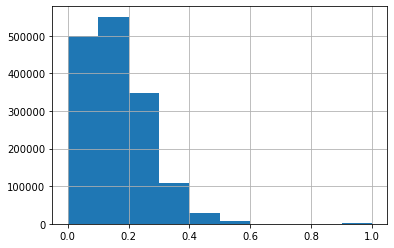

In [153]:
# histograma de la matriz de proximidad
prox_1719_numpy.unstack().hist()

In [ ]:
def my_own_proximity_matrix(mvcr, fillna=False):
    products = sorted(list(mvcr.columns))                     # lista ordenada de productos
    num_products = len(products)                              # cantidad de bienes de la base 
    proximity = np.empty((num_products, num_products))        # armo una matriz vacía de nxn siendo n = cant prod
    col_sums = mvcr.sum().values                              # sumo elementos de las cols (nro de paises que exportan cada bien)
    data = mvcr.T.to_numpy()                                  # reemplazo as_matrix() por to_numpy() ya que "Deprecated since version 0.23.0"
    for i in range(0,num_products):
        for j in range(0,num_products):
            P_i = 
            P_j = 
            P_conj_ij = 
            numerator = (data[i] * data[j]).sum()
            denominator = max(col_sums[i], col_sums[j])
            if denominator == 0.0:
                cond_prob = np.nan
            else:
                cond_prob = numerator / denominator
            proximity[i][j] = cond_prob
            proximity[j][i] = cond_prob
    # Return DataFrame Representation #
    proximity = pd.DataFrame(proximity, index=products, columns=products)
    proximity.index.name = 'product_i'
    proximity.columns.name = 'product_j'
    if fillna:
        proximity = proximity.fillna(0.0)
    return proximity

Pendientes ==> Ver si amerita unificar cantidad de países en todos los años estudiados ya que no hay igual información disponible para cada período